# Spectral Leakage

Two key problems arise when conducting spectral analysis of finite, discrete time series (not an infinite time series):

1. **Aliasing:** we only resolve frequencies lower than the Nyquist frequency ($\frac{1}{2\Delta t}$), and frequencies higher than this get aliased to lower frequencies.

2. **Spectral Leakage:** we assume that all waveforms stop and start at $t$ = 0 and $t$ = $T$, but in the real world, many of these wave numbers may not complete a full integer number of cycles throughout the domain, causing spectral leakage to other wave numbers.

In this section, we will address the second problem, **spectral leakage** and how to reduce it.

## Setting up the problem

Suppose we have a time series, $y(t)$, that is defined on -$\infty \leq t \leq \infty$. 

Another way to conceptualize this time series would be to write it as, $y(t)g(t)$, where $g(t)$ is a function with a value of 1 for all $t$, -$\infty \leq t \leq \infty$, as illustrated in the left panel in [Figure 23](window).

```{figure} window.png
---
scale: 50%
name: window
---
Schematic comparing the window function of an infinite time series, with that of a finite time series
```

But what we really have is a time series, $y(t)$, that is defined a time interval from 0 $\leq t \leq T$. Applying the same conceptualization as above, we can denote this time series, $y(t)g(t)$, where now, $g(t)$ now has a value of 1 over the range 0 $\leq t \leq T$ and a value of zero for all other times, as illustrated in the right panel in [Figure 23](window).

$g(t)$ in the case of a finite time series can be thought of as a *window* and this window can act to cut-off incomplete cycles and cause spectral leakage. But what is spectral leakage, really? Let's take a look at an example using a simple sine wave.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.signal as sig

Let's define a sine function on a time domain, such that the sine function completes $N$, integer cycles, i.e., no cycles are cut-off within the domain.

In [2]:
# define parameters

# length of time domain
T = 8*np.pi

# time variable
t = np.arange(0,T+0.05*np.pi,0.05*np.pi)

# frequency
freq = np.arange(0,int(len(t)/2.0)+1)/len(t)

Now, we can define and plot our sine function.

In [3]:
# Define sine function
y1 = np.sin(t)

Text(0.5, 1.0, 'Sine Wave')

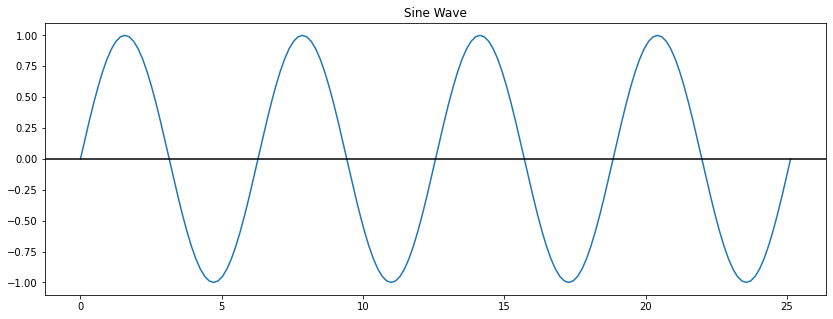

In [4]:
# Plot sine function
plt.figure(figsize=(14,5))
plt.plot(t,y1)
plt.axhline(0,color='k')
plt.title("Sine Wave")

Here, we have 4 complete cycles of our sine wave. Now, let's compute the discrete power spectrum of this sine wave. 

In [5]:
# compute FFT
yfft1_raw = np.fft.fft(y1)
yfft1 = yfft1_raw/len(y1)

# compute variance as a function of frequency (spectral power)
ck2y1 = 2*np.abs(yfft1[0:int(len(t)/2.0+1)])**2

What do you think it will look like?

Text(0.5, 1.0, 'Discrete Power Spectrum for Un-windowed Sine Wave')

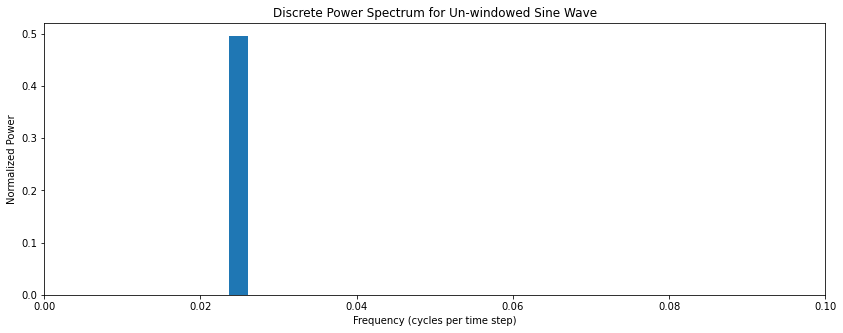

In [6]:
# Plot normalized power as a function of frequency
plt.figure(figsize=(14,5))
plt.bar(freq,ck2y1,width=0.0025)
plt.xlabel('Frequency (cycles per time step)')
plt.ylabel('Normalized Power')
plt.xlim(0,0.1)
plt.title("Discrete Power Spectrum for Un-windowed Sine Wave")

We get a single spectral peak corresponding to the frequency of our sine wave.

Now, let's see what happens if we apply a *window* to our sine wave that cuts off the sine wave such that the sine function does not complete an integer number of cycles within the time domain.

In [7]:
# Now let's window our data, such that we are not cleanly sampling our sine function
y2 = []
bxcr = []
for i in t:
    if (i < 1.5*np.pi) or (i > 6.5*np.pi):
        y2.append(0)
        bxcr.append(0)
    else:
        y2.append(np.sin(i))
        bxcr.append(1)
y2 = np.asarray(y2)
bxcr = np.asarray(bxcr)

Above, we created a window function called `bxcr` (short for box-car) and our cut-off sine wave. Let's plot these to see what they look like. Notice that if we multiply `bxcr` and our original sine wave together we get the modified sine wave.

Text(0.5, 1.0, 'Also a Windowed Sine Wave')

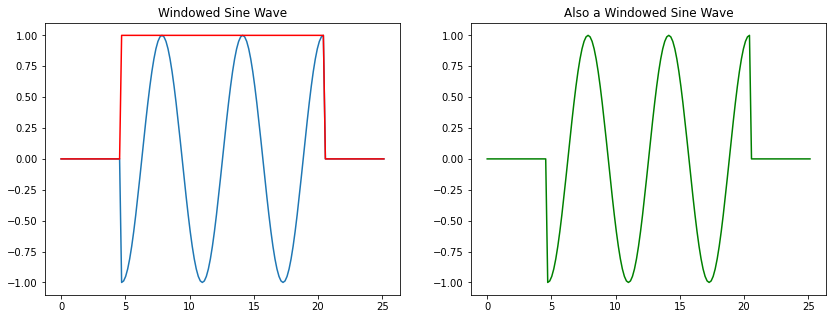

In [8]:
# Plot windowed sine wave, window
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(t,y2)
plt.plot(t,bxcr,'r')
plt.title('Windowed Sine Wave')

plt.subplot(1,2,2)
plt.plot(t,y1*bxcr, 'g')
plt.title('Also a Windowed Sine Wave')

To demonstrate what spectral leakage is, we will now compute the discrete power spectrum of the windowed sine wave to see what happens.

In [9]:
# compute FFT
yfft2_raw = np.fft.fft(y2)
yfft2 = yfft2_raw/len(y2)

# compute variance as a function of frequency (spectral power)
ck2y2 = 2*np.abs(yfft2[0:int(len(t)/2.0+1)])**2

Text(0.5, 1.0, 'Discrete Power Spectrum for Windowed Sine Wave')

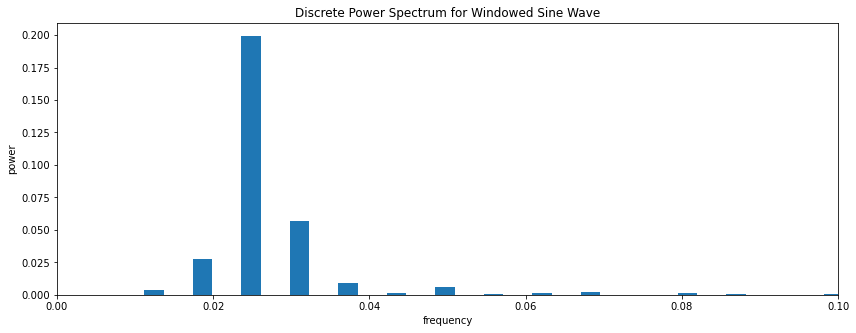

In [10]:
# Plot Power Spectrum of windowed data
plt.figure(figsize=(14,5))
plt.bar(freq,ck2y2,width=0.0025)
plt.xlabel('frequency')
plt.ylabel('power')
plt.xlim(0,0.1)
plt.title("Discrete Power Spectrum for Windowed Sine Wave")

What happened? Our Fourier Transform is not able to clearly isolate the sine wave frequency as the only frequency. This is the essense of spectral leakage and it is problematic because it can introduce frequencies in time series that are not actually there. In order to better understand how windowing can result in spectral leakage, we need learn a bit about **convolution**.

## Convolution

We can minimize spectral leakage by applying different *windows* to our data, i.e., by creating different functional forms for $g(t)$. To understand how applying different windows can help, we first need to define something called **convolution**.

The convolution of two functions $y(t)$ and $g(t)$ is:

$$
(g * y)(t) = \int_{-\infty}^{\infty} g(\tau)y(t-\tau) \,d\tau
$$

where the ($*$) symbol denotes a convolution. Let's do an example to see what this equation is actually telling us (turns out it isn't that complicated!).

```{admonition} Example
:class: tip

Let $g(\tau)$ = $[$0 $\frac{1}{3}$ $\frac{1}{3}$ $\frac{1}{3}$ 0$]$ for $\tau$ = -2, -1, 0, 1, 2

Let $y(t)$ = $[$9 7 8 6 5 4 3 8 9 10 11$]$ for $t$ = 1, 2, 3, 4,…

($g * y$)(t = 4) = 7 · 0 + 8 · $\frac{1}{3}$ + 6 · $\frac{1}{3}$ + 5 · $\frac{1}{3}$ + 4 · 0 = $\frac{19}{3}$
```

Thus, the convolution is really just a *sliding window*, or, a *sliding weighted average*! $g(\tau)$ could be any function, for example, the window in the right panel of [Figure 23](window) above.

We have seen something similar to convolution in Assignment 2, [**cross-correlation**](https://www.youtube.com/watch?v=Ma0YONjMZLI).

This brings us to the **Convolution Theorem**

```{admonition} Convolution Theorem
:class: note
The convolution theorem tells us that the Fourier Transform of the product of two functions is the convolution of their individual Fourier Transforms (and vice versa).
```

Mathematically, we write,

$$
\begin{align}
\mathcal{F}(y(t)g(t)) &= \mathcal{F}(y(t))*\mathcal{F}(g(t))\\
& = \mathcal{Y}(\omega) * \mathcal{G}(\omega)
\end{align}
$$

and

$$
\begin{align}
\mathcal{F}(y(t)*g(t)) &= \mathcal{F}(y(t))\mathcal{F}(g(t))\\
& = \mathcal{Y}(\omega)\mathcal{G}(\omega)
\end{align}
$$

where $\mathcal{F}$ is the Fourier Transform operator and fancy capital letters denote the Fourier Transform of their lower-case functions. And recall that,

$$
y(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} Y(\omega)e^{i\omega t} \,d\omega
$$

and

$$
Y(\omega) = \int_{-\infty}^{\infty} y(t)e^{-i\omega t} \,dt
$$

Now, what does all this mean for spectral leakage? So, back to [Figure 23](window): if we have a finite time series, $y(t)$, when we take its Fourier Transform, what we are really doing is taking the Fourier Transform of $y(t)g(t)$! Cool! So, the Convolution Theorem then tells us that the Fourier Transform of $y(t)g(t)$ is the convolution of the individual Fourier Transforms resulting in **spectral leakage**. 

Mathematically, the Convolution Theorem tells us that if, 

$$
\begin{align}
\mathcal{F}(y(t)g(t)) &= \int_{-\infty}^{\infty} y(t)g(t)e^{-i\omega t} \,dt
\end{align}
$$

then,

$$
\begin{align}
\mathcal{F}(y(t)g(t)) &= \mathcal{F}(y(t))*\mathcal{F}(g(t))\\
& = \mathcal{Y}(\omega) * \mathcal{G}(\omega)\\
& = \int_{-\infty}^{\infty} \mathcal{Y}(\omega_0)\mathcal{G}(\omega-\omega_0) \,d\omega_0
\end{align}
$$

So, the Fourier Transform of our discrete and finite time series $y(t)$ with window $g(t)$ can be found by convolving the individual Fourier Transforms $\mathcal{Y}(\omega)$ and $\mathcal{G}(\omega)$!

One way to think about this is that our infinite Fourier Transform $\mathcal{Y}(\omega)$ gets smoothed out by a moving weighted average that looks like the Fourier Transform of $g(t)$ (namely, $\mathcal{G}(\omega)$).

Let's revisit the sine wave example above to see what this works. First, let's compute the FFT of the window, `bxcr` and plot the power spectrum.

In [11]:
# compute FFT
bfft_raw = np.fft.fft(bxcr)
bfft = bfft_raw/len(bxcr)

# compute variance as a function of frequency (spectral power)
ck2bxcr = 2*np.abs(bfft[0:int(len(t)/2.0+1)])**2

Text(0.5, 1.0, 'Discrete Power Spectrum for Boxcar Function')

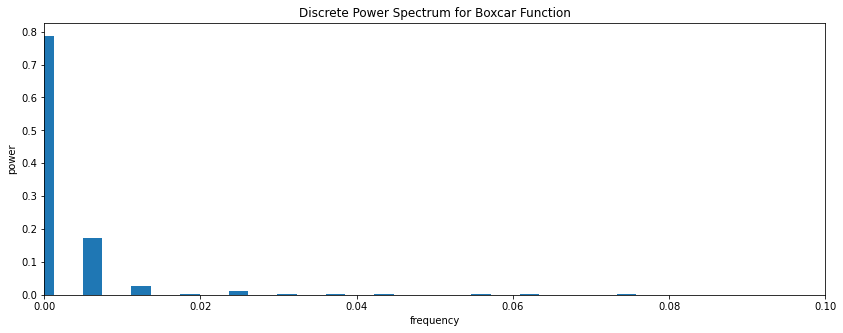

In [12]:
# Plot Power spectrum of boxcar window
plt.figure(figsize=(14,5))
plt.bar(freq,ck2bxcr,width=0.0025)
plt.xlabel('frequency')
plt.ylabel('power')
plt.xlim(0,0.1)
plt.title("Discrete Power Spectrum for Boxcar Function")

We can test the convolution theorem, by convolving the two individual Fourier Transforms of `y1` and `bxcr` and see if we get the Fourier Transform of their product, `y2`. Note, that the [most efficient way to do this convolution in python and to avoid issues with zero-padding using the `np.convolve` function, etc.](http://greenteapress.com/thinkdsp/html/thinkdsp009.html) is to apply the [convolution Theorem for the Inverse Fourier Transform](https://en.wikipedia.org/wiki/Convolution_theorem#Convolution_theorem_for_inverse_Fourier_transform). 

In [13]:
# Convolution of y1 and bxcr using inverse FFT
cfft = np.fft.ifft(np.fft.fft(yfft1)*np.fft.fft(bfft))

# compute variance as a function of frequency (spectral power)
ck2c = 2*np.abs(cfft[0:int(len(t)/2)+1])**2

Let's plot thie discrete power spectrum. We should get something that looks like the discrete power spectrum for `y2`.

Text(0.5, 1.0, 'Discrete Power Spectrum for Boxcar Function')

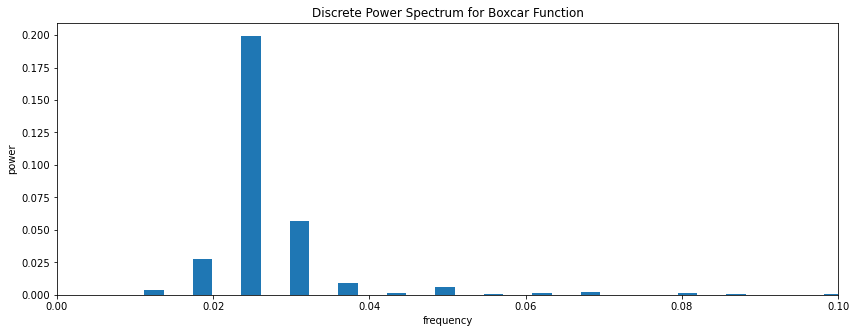

In [14]:
plt.figure(figsize=(14,5))
plt.bar(freq,ck2c,width=0.0025)
plt.xlabel('frequency')
plt.ylabel('power')
plt.xlim(0,0.1)
plt.title("Discrete Power Spectrum for Boxcar Function")

We see that we can recover the windowed discrete power spectrum of `y2` when we convolve the Fourier Transforms of the individual time series, `y1` and `bxcr`.

## Response Functions

The function $\mathcal{G}(\omega-\omega_0)$ is called the response function of window $g(t)$ that acts on the original time series (where $g(t)$ is a window in time, not in frequency).

*Ideal Case (no window):*

In an ideal world, we would like our window $g(t)$ to give us a response function of $\mathcal{G}(\omega-\omega_0)$ such that,

$$
\begin{align}
\mathcal{G}(\omega-\omega_0) &= 1 \quad \text{when $\omega = \omega_0$}\\
\mathcal{G}(\omega-\omega_0) &= 0 \quad \text{when $\omega \neq \omega_0$}\\
\end{align}
$$ 

That is, a delta function at lag 0 (or, where $\omega=\omega_0$).

*Boxcar Window*:

In reality, the response function for our discrete window is very different from this, for example, consider the naive window that we all automatically use when analyzing discrete data, i.e. the Boxcar Window:

$$
\begin{align}
g(t) &= 1 \quad \text{when $0 \leq t \leq T$}\\
g(t) & = 0 \quad \text{for all other $t$}
\end{align}
$$

The Fourier Transform of the Boxcar Function is:

$$
\begin{align}
\mathcal{G}(\omega) &= \frac{\text{sin}(\omega T/2)}{\omega T/2}\\
 &= sinc(\omega T/2\pi)
\end{align}
$$ 

where the normalized $sinc$ function is defined as,

$$
sinc(x) = \frac{\text{sin}(\pi x)}{\pi x}
$$

Let's plot the $sinc$ function and see what it looks like. 

In [15]:
# Response function for boxcar window for different values of T
bxcr_response = []
freq = []
for i in range(1,102):
    T = i*np.pi
    # time variable
    t = np.arange(0,T+0.05*np.pi,0.05*np.pi)
    # frequency
    freq_tmp = np.arange(0,int(len(t)/2.0)+1)/len(t)
    
    bxcr_response.append(np.sinc(freq_tmp*T/(2*np.pi)))
    freq.append(freq_tmp)

Plot this response function as a function of frequency. Note that this is not a plot of power. This plot corresponds to the Fourier Transform of the boxcar window.

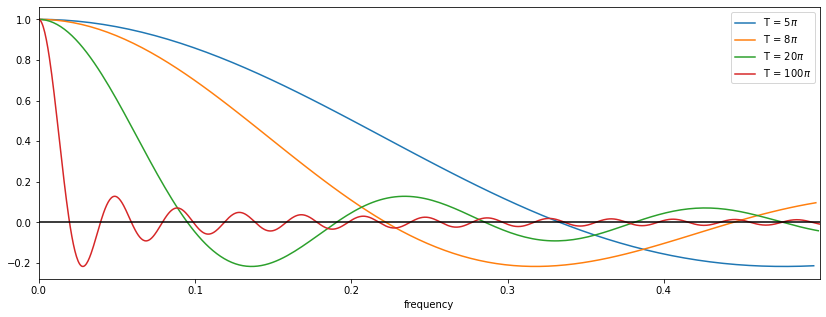

In [16]:
# plot response functions for different values of T
plt.figure(figsize=(14,5))
for i in (5,8,20,100):
    plt.plot(freq[i],bxcr_response[i],label = 'T = '+str(i)+'$\pi$')
plt.axhline(0,color='k')
plt.xlim(0,freq[i][-1])
plt.xlabel('frequency')
plt.legend()

Recall why we are looking at this: The Fourier Transform of a windowed time series corresponds to the convolution of the individual Fourier Transforms (convolution theorem!). Thus, the above plot shows the function that is being *convolved* with the pure periodic signal in our time series leading to spectral leakage. Remember that a convolution can be thought of as a sliding weighted average.

So, what do you see? The ideal response function, as described above, should just be a step function, i.e. it should have a value of 1 at lag = 0 (in this plot, $\omega$ = 0) and a value of 0 everywhere else. This is not what we see for the boxcar window. We do see a value of 1 at lag = 0, but we see many other non-zero values at higher lags. Notice the large negative side lobe and their rather slow, oscillatory decay. We also see that as $T$ gets larger, the boxcar function approaches a step function, but never truly gets there.

#### Characteristics of the Boxcar Window Response Function:

- **smoothing:** when the spectrum is calculated through a boxcar, the window acts to smooth and distort the true spectrum.

- **side lobes:** note the side lobes, these can be a real problem as they add frequencies to your spectrum that may not have been present in your original data - the reason for the side lobe is that these are the higher frequency harmonics needed to try and fit the sharp corners of the boxcar window.

- **small T:** note that for small T, the frequency window (response function) is much wider, and thus, there is more smoothing among the different frequencies.

- **large T:** for large T, the frequency window (response function) is more like a delta function, and becomes closer and closer to the ideal response function. For large T, this makes sense, because the edges of your “boxcar” are just a tiny part of your data.

## Alternative Windows for Minimizing Spectral Leakage

As we have seen, the boxcar window causes spectral leakage, thus, alternative *windows* have been developed in order to reduce this problem. Here, we will focus on one called the **Hanning Window**.

The Hanning window is one of many windows that acts to taper the end of the time series, rather than have a sharp rectangular corner, like a boxcar window. The functional form of the Hanning window is:

$$
h(t) = \frac{1}{2}\left(1-\text{cos}(\frac{2\pi t}{T})\right) \quad \text{when $0 \leq t \leq T$}
$$

Notice the smooth edges of the Hanning window in [Figure 24](hann).

```{figure} Boxcar_Hanning_timedomain.png
---
scale: 80%
name: hann
---
Schematic comparing the Boxcar window and Hanning window in the time domain.
```


The response function of the Hanning window (i.e., the Fourier Transform) is as follows,

$$
\mathcal{G}(\omega) = sinc(\omega T/2\pi) + \frac{1}{2}\left(sinc(\omega T/2\pi+1) + sinc(\omega T/2\pi-1)\right)
$$

The first term in the Hanning window response function is identical to the boxcar response function and the last two terms act to approximately cancel the negative side lobes.

In [17]:
# Response function for Hanning window
T = 20*np.pi
# time variable
t = np.arange(0,T+0.05*np.pi,0.05*np.pi)
# frequency
freq = np.arange(0,int(len(t)/2.0)+1)/len(t)

bxcr_response = np.sinc(freq*T/(2*np.pi))
hann_response = np.sinc(freq*T/(2*np.pi)) + 0.5*(np.sinc(freq*T/(2*np.pi) + 1) + np.sinc(freq*T/(2*np.pi) -1))

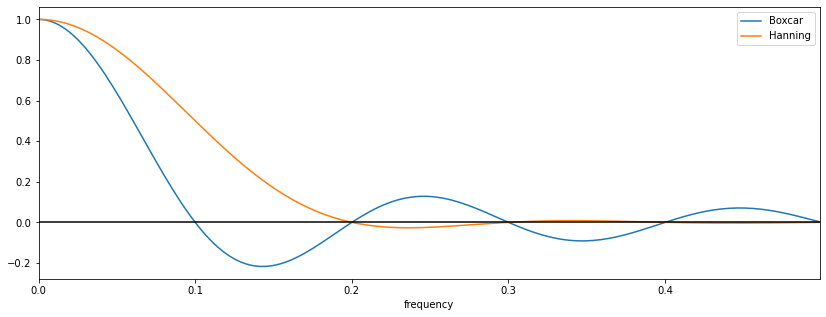

In [18]:
# plot response functions for different values of T
plt.figure(figsize=(14,5))
plt.plot(freq,bxcr_response,label = 'Boxcar')
plt.plot(freq,hann_response,label = 'Hanning')
plt.axhline(0,color='k')
plt.xlim(0,freq[-1])
plt.xlabel('frequency')
plt.legend()

### Windows and Degress of Freedom

Note that this additional smoothing isn't considered in your degrees of freedom (D.O.F.) calculation, and thus, there is an additional factor added into the D.O.F. calculation to account for the smoothing by the window:

$$
DOF = \frac{N}{M^*}f_w
$$

where $f_w$ is a factor to compensate for the extra smoothing by the window. It is generally between 1 and 1.5 depending on how much smoothing the window does. For a Hanning window, $f_w$ = 1.2.

## Welch's Overlapping Segment Analysis Method

One of the problems with the Hanning window, is that if you have a short time series, you will end up using very little of the data at the edges of your time series due to the tapered window But, this data is just as important as the data in the center of the time series! This is not only a problem for short time series, but it can also, be a problem when you split your time series into smaller chunks to construct a continuous power spectrum and increase your degrees of freedom. 

For example, we might want to split our time series into 2 chunks (see [Figure 25](wosa) below). To reduce tapering at the edges, often one will apply the window to one chunk of data, and include a 50\% overlap with that data when calculating the second chunk of data. In this case, you will have more than 2 chunks (you will have 3 chunks). It turns out that even though it may feel like you are double counting data, you actually gain 2 degrees of freedom per chunk (including those overlapping) if you are using a Hanning window. That is, if you use a 50\% overlap with a Hanning window you will have 3 x 2 x 1.2 = 7.2 degrees of freedom per spectral estimate!

```{figure} WOSA.png
---
scale: 50%
name: wosa
---
Schematic of Welch's Overlapping Segment Analysis (WOSA) Method for two chunks.
```

Let's take a look at the python function `scipy.sig.welch` that we have used previously, now that we know a bit more about it and its connection to the issue of spectral leakage. We will use cosine wave time series with a bit of white noise to test the `sig.welch` function.

We are also going to divide the time series into 4 chunks, so you will see a new parameter below for the number of chunks. Use the "Live Code/Lauch Thebe" button to see how the power spectrum changes if you change the number of chunks. Try 1, 2 and 8 chunks.

In [19]:
# input parameters
T = 256         #length of time series
N = 4           #number of chunks
alpha = 0.5     #red noise lag-one autocorrelation
beta = np.sqrt(1.-alpha**2)  #beta, red noise parameter

T2 = T/(2*N)
freq = np.arange(0.,T2+1.)/(T/N)

Calcalute the red noise spectrum:

In [20]:
# contstruct expected red noise spectrum 
rspec = []
for h in np.arange(0,T2+1,1):
    rspec.append((1.-alpha**2)/(1.-2.*alpha*np.cos(np.pi*(h)/T2)+alpha**2))

Now, we will do the same procedure that we did in the last section, except that we will change the argument, `nperseg` in the `sig.welch` function to indicate the size of each chunk.

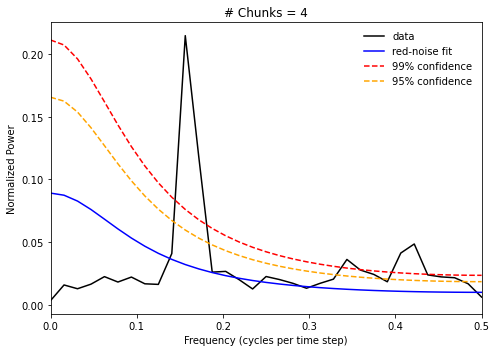

In [21]:
# initialize array for zeros for synthetic time series
x = np.zeros(T,)

# construct synthetic time series (note the f for the cosine wave is approximate 0.2)
x[0] = beta*np.random.randn()

for j in np.arange(1,T,1):
    x[j] = 0.5*np.cos(j) + 0.75*beta*np.random.randn()

# compute power spectrum (try window = "boxcar" for comparison)
p = sig.welch(x,window='hanning', nperseg=int(T/N))
pave = p[1]

# normalize the spectrum
pave = pave/np.sum(pave)

# calculate significance using F-test
dof = 2*N*1.2
fstat = st.f.ppf(.99,dof,1000)
spec99 = [fstat*m for m in rspec]
    
fstat = st.f.ppf(.95,dof,1000)
spec95 = [fstat*m for m in rspec]
    
# plot power spectrum and red noise spectra
plt.figure(figsize=(7,5))
plt.xlabel('Frequency (cycles per time step)')
plt.ylabel('Normalized Power')
plt.title('# Chunks = 4')
plt.xlim(0,0.5)
plt.plot(freq,pave,'-k', label = 'data')
plt.plot(freq,rspec/np.sum(rspec),'-', label = 'red-noise fit', color = 'blue')
plt.plot(freq,spec99/np.sum(rspec),'--', label = '99% confidence', color = 'red')
plt.plot(freq,spec95/np.sum(rspec),'--', label = '95% confidence', color = 'orange')
plt.legend(frameon = False)
plt.tight_layout()

You should notice that the spectral peak gets wider as we increase the number of chunks. This is because we are losing information as the time segments get shorter; however, the WOSA method is still able to identify the correct frequency for the peak and as we increase the number of chunks, the peak corresponding to the periodic frequency in our data emerges as the only significant one - reducing spectral leakage.